In [2]:
import pandas as pd
from itables import init_notebook_mode
from itables import show
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from textwrap import wrap
import numpy.polynomial as poly
import time
from openai import OpenAI
import os
import re

from tqdm import tqdm

import pickle


In [4]:
data_folder = 'data/'

world_happiness_file = 'world_happiness.csv'
column_renames = {
    'Country name': 'country',
    'value': 'whp',
}    

In [6]:
world_happiness_df = pd.read_csv(data_folder +world_happiness_file)
world_happiness_df = world_happiness_df.rename(columns=column_renames).melt(id_vars=['country','year'],var_name='series',value_name='whp')
world_happiness_df = world_happiness_df.loc[world_happiness_df['series'] == "Life Ladder"]
world_happiness_df['whp'] = pd.to_numeric(world_happiness_df['whp'])

In [8]:
chatgpt_happiness_df = pd.DataFrame(world_happiness_df['country'].unique())
chatgpt_happiness_df.rename(columns={0:'country'},inplace=True)
chatgpt_happiness_df['year'] = 2023


In [10]:
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [12]:
def happiness_by_chatgpt(row):
    """Calls chatGPT 
    """
    # system = f"You are an average person living in {row['country']} in year {row['year']}."
#     question1 = "How would you rate your current life as a whole using the image of a ladder, \
# with the best possible life for you as a 10 and worst possible as a 0? Provide your \
# answer with an exact number with decimals instead of a range and the sections explaining \
# the reasons that drives the number higher and the reasons that drives the number lower."
    question2 = f'If you are to survey 1000 randomly sampled people in {row["country"]} in the year {row["year"]} with \
the question of, \
"Evaluate your current life as a whole using the image of a ladder, with the best possible life for you as \
a 10 and worst possible as a 0", what do you think the average would be. Provide your answer with an exact \
number with two decimal points instead of a range and the sections explaining the reasons that drives the number \
higher and the reasons that drives the number lower. '
    
    completion = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        # {"role": "system", "content": system},
        {"role": "user", "content": question2}
      ]
    )
    return completion.choices[0].message.content



In [225]:
with open("japanonly_chatgpt_happiness_df.pkl", "wb") as f:
  # Pickle the dictionary and write it to the file
  pickle.dump(japanonly_chatgpt_happiness_df, f)


In [118]:
%%time

tqdm.pandas()

chatgpt_happiness_df['raw answer'] = chatgpt_happiness_df.progress_apply(happiness_by_chatgpt,axis=1)
    


100%|██████████| 165/165 [26:55<00:00,  9.79s/it]

CPU times: total: 1.36 s
Wall time: 26min 56s


In [119]:
with open("chatgpt_happiness_df_q2.pkl", "wb") as f:
  # Pickle the dictionary and write it to the file
  pickle.dump(chatgpt_happiness_df, f)


sns.lineplot(combined_df,x='year',y

In [180]:
pattern = r"(\d+\.\d+)"

chatgpt_happiness_df['chatgpt'] = chatgpt_happiness_df['raw answer'].str.extract(pattern,expand=False)
chatgpt_happiness_df['chatgpt'] = pd.to_numeric(chatgpt_happiness_df['chatgpt'])

In [182]:
show(chatgpt_happiness_df[['country','chatgpt']])

In [186]:
combined_df = pd.merge(world_happiness_df,chatgpt_happiness_df,on=['country','year'],how="left")

In [188]:
combined_df['diff'] = combined_df['whp'] - combined_df['chatgpt']

In [210]:
df = combined_df.loc[combined_df['year']==2023,['country','whp','chatgpt','diff']]

In [194]:
from scipy.stats import wilcoxon
statistic, pvalue = wilcoxon(df['whp'], df['chatgpt'])

# Print the results
print("Wilcoxon signed-rank statistic:", statistic)
print("p-value:", pvalue)

Wilcoxon signed-rank statistic: 2740.0
p-value: 1.2507097485888644e-05


In [200]:
from scipy.stats import ttest_rel
statistic, pvalue = ttest_rel(df['whp'], df['chatgpt'])

# Print the results
print("Paired samples t-test statistic:", statistic)
print("p-value:", pvalue)
print(f"p-value: {pvalue:.10f}")



Paired samples t-test statistic: -4.789265532258102
p-value: 4.288731680959525e-06
p-value: 0.0000042887


In [ ]:
{"custom_id": "request-1", "method": "POST", "url": "/v1/chat/completions", "body": 
 {"model": "gpt-3.5-turbo-0125", "messages": [{"role": "system", "content": "You are a helpful assistant."}
                                              ,{"role": "user", "content": "Hello world!"}],"max_tokens": 1000}}


In [214]:
show(df)

## One country

In [288]:
temp_chatgpt_happiness_df = world_happiness_df.loc[world_happiness_df['country']=='China',['country','year']]
temp_chatgpt_happiness_df['raw answer'] = temp_chatgpt_happiness_df.progress_apply(happiness_by_chatgpt,axis=1)
    
    


100%|██████████| 17/17 [02:14<00:00,  7.94s/it]


<AxesSubplot: xlabel='year', ylabel='values'>

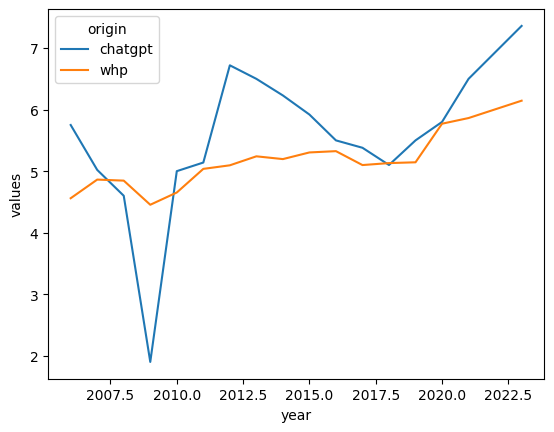

In [289]:
pattern = r"(\d+\.\d+)"
temp_chatgpt_happiness_df['chatgpt'] = temp_chatgpt_happiness_df['raw answer'].str.extract(pattern,expand=False)
temp_chatgpt_happiness_df['chatgpt'] = pd.to_numeric(temp_chatgpt_happiness_df['chatgpt'])

combined_df = pd.merge(world_happiness_df,temp_chatgpt_happiness_df,on=['country','year'],how="right")
melted_df = combined_df.loc[:,['country','year','chatgpt','whp']].melt(id_vars=['country','year',],var_name='origin',value_name='values')
sns.lineplot(melted_df,x='year',y='values',hue='origin')

## Batch work


In [14]:
from itertools import product

years = list(range(1970,2024))
countries = world_happiness_df['country'].unique()

chatgpt_batch_df = pd.DataFrame(list(product(countries, years)),columns=["country","year"])

In [16]:
def generate_json(row):
    question = f'If you are to survey 1000 randomly sampled people in {row["country"]} in the year {row["year"]} with \
the question of, \
"Evaluate your current life as a whole using the image of a ladder, with the best possible life for you as \
a 10 and worst possible as a 0", what do you think the average would be. Provide your answer with an exact \
number with two decimal points instead of a range and the sections explaining the reasons that drives the number \
higher and the reasons that drives the number lower. '
    
    json_dict = {
        "custom_id": f"{row['country']}-{row['year']}", 
        "method": "POST", 
        "url": "/v1/chat/completions", 
        "body": 
             {"model": "gpt-4o", "messages": 
              [
                #{"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": question}]
             }
             
        }
    return json.dumps(json_dict)

In [18]:
chatgpt_batch_df['json'] = chatgpt_batch_df.apply(generate_json,axis=1)

In [20]:
batchfile = "prompts.jsonl"

chatgpt_batch_string = chatgpt_batch_df.to_string(columns=['json'],header=False,index=False)
# Open a text file in write mode and write the string
with open(batchfile, 'w') as f:
  f.write(chatgpt_batch_string)

In [22]:
batch_input_file = client.files.create(
  file=open(batchfile, "rb"),
  purpose="batch"
)

In [26]:
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "world happiness simulation"
    }
)

Batch(id='batch_OrXMJY9VXMoBH8z17hmsu9od', completion_window='24h', created_at=1715823276, endpoint='/v1/chat/completions', input_file_id='file-hcC0oI1pxCx13dwZKWfFJLsM', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1715909676, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'world happiness simulation'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))